<a href="https://colab.research.google.com/github/javadch/covid19/blob/master/Covid19_Cases_Germany.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a try to understand the behavior of the Coronavirus in Germany using data.
The data is obtained from [ECDC](https://www.ecdc.europa.eu) which is free and open. The dataset that is used in this study contains worldwide cumulative counts for new confirmed, deaths, and recovered cases. However, that may have missing values, especially in the recovered cases.
In this study, China has been used as a baseline to be able to compare German data and be able to make sense of the situation.
You can find information about the author [here](https://www.tib.eu/en/research-development/data-science-digital-libraries/staff/javad-chamanara/).

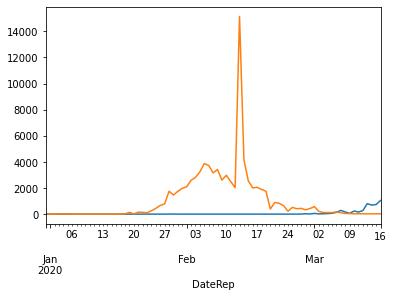

In [9]:
# Use of the EUDAT data
from datetime import datetime
from datetime import timedelta
import pandas as pd
import requests
import io

nowUtc = datetime.utcnow()
url_pattern = 'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-YYYY-MM-DD.xls'
# It is possible that ECDC has not yet uploaded the today's data.
# In this case, I fallback to yesterday's dataset
try:
  url = url_pattern.replace('YYYY', '{:04d}'.format(nowUtc.year)).replace('MM', '{:02d}'.format(nowUtc.month)).replace('DD', '{:02d}'.format(nowUtc.day))
  #print(url) 
  data = pd.read_excel(url, index_col=0) 
except: # fallback to yesterday
  nowUtc = nowUtc- timedelta(days=1)
  url = url_pattern.replace('YYYY', '{:04d}'.format(nowUtc.year)).replace('MM', '{:02d}'.format(nowUtc.month)).replace('DD', '{:02d}'.format(nowUtc.day))
  #print(url) 
  data = pd.read_excel(url, index_col=0) 
germany = data[(data['GeoId'] == "DE")].sort_values(by=['DateRep'], ascending=True)
china   = data[(data['GeoId'] == "CN")].sort_values(by=['DateRep'], ascending=True)
#print(germany.head(10))
germany['NewConfCases'].plot()
china['NewConfCases'].plot()

The figure above shows that China is flattening the curve, while Germany if facing its exponential spreading phase. In order to zoom over that surging timespan, we draw the chart for Germany only in the following code block. With an exception on March the 9th (which is still not clear what has happened there), the chart indicates a clear exponential behavior starting from 28.01.2020.

The first recorded incident in China: DatetimeIndex(['2019-12-31'], dtype='datetime64[ns]', name='DateRep', freq=None)
The first recorded incident in Germany: DatetimeIndex(['2020-01-28'], dtype='datetime64[ns]', name='DateRep', freq=None)


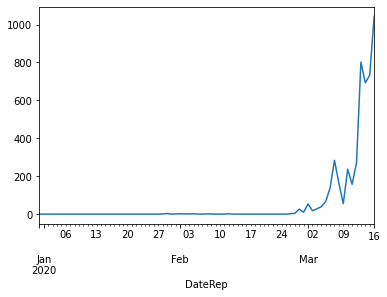

In [10]:
from datetime import datetime
germany['NewConfCases'].plot()
# The date of the first recorded incident in China
print('The first recorded incident in China:', china[(china['NewConfCases']>0)].head(1).index)
# The date of the first recorded incident in Germany
print('The first recorded incident in Germany:', germany[(germany['NewConfCases']>0)].head(1).index)

One interesting observation here is that the first positive records in China and Germany where on 31.12.2019 and 28.01.2020 respectively, indicating 28 days shift. This implies that Germany has been able to keep itself safe from the virus for 4 weeks. 

However, afterwards, the virus has spread very quickly! It means that the seed spreading should have happened in a highly-populated area or in an event with remarkable close contacts between a large number of people.

Another important point to study is that the spreading speed in Germany is exponential but in the case of China (except for that middle pick) the slope looks like a linear or a mild polynomial one. Should this be interpreted as the results of policies and actions implemented in China?

However, a good fact about Corona in Germany is that the number of deaths is outstandingly low and almost constant (even better than linear).

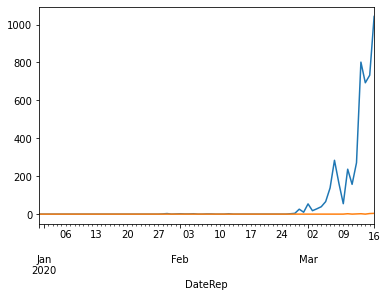

In [11]:
germany['NewConfCases'].plot()
germany['NewDeaths'].plot()

To see the trend of death cases better, in the following code block I draw it without the other charts. The charts shows daily new and cumulative incidents.

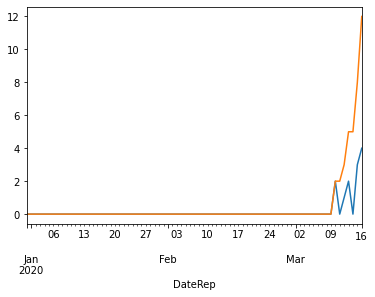

In [12]:
germany['NewDeaths'].plot()
germany['NewDeaths'].cumsum().plot()

And if we calculate and draw the fatality rate, we can see this even better. The fatality rate is the percentage of people who contract the coronavirus and then die. To calculate the ratio, we have two models:
1. $Deaths/TotalCases$: This model is likely to be an underestimate because lots of open cases can still end up in death.
2. $Deaths/ClosedCases$: Closed cases is the sum of death and recovered cases. This model is an overestimate because it’s likely that deaths are closed quicker than recoveries. 

Model 1 will show a lower rate in the beginning and increases when the epidemy is getting contained. Model 2 behaves the other way round. Therefore, it would be good to calculate and draw both of them and observe how they converge over time.

**Unfortunately**, the current dataset does not provide the recovered cases. So, I am relying on model 1.

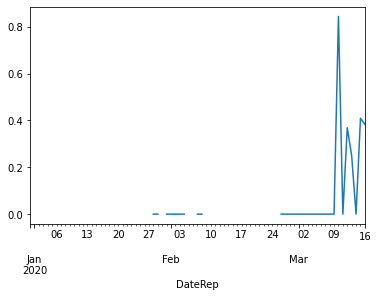

In [13]:
germany['FatalityRate'] = 100*germany['NewDeaths']/germany['NewConfCases']
germany['FatalityRate'].plot()
death_days_germany = germany[germany['NewDeaths'] > 0].count()['NewDeaths'] # number of days with death records
death_germany = germany['NewDeaths'].sum() # total number of deaths recorded

The fatality rate is well bellow 1% which is much better than that of China.
Also, there were only 4 days with death records with a total casualty of 8 so far (15.03). This is on average one death per 10 million; very promising.
However, as the epidemic has already entered its exponential phase, expecting higher fatality should not be surprising, as the indicators are appearing. See the following diagram that shows the death chart is also entring its exponential phase!

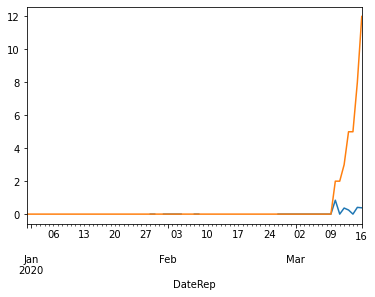

In [14]:
germany['FatalityRate'].plot()
germany['NewDeaths'].cumsum().plot()

# Recorded cases versus real cases
Throughout this study, I am referring to `recorded` cases instead of simply saying cases. This is because in biological epidemics there is a time lag between getting affected and being identified.
The data source used in this study collected the date that the cased are identified. Which means the report is behind the virus movement.

According to sources, the virus enjoys a 5 day incubation time $(it)$. After this time, if the patient receives medical aid, gets diagnosed, tested, and registered, it takes, on average, 3 more days $(lt)$ to identify whether she/he was a case. 
We can also assume that people do not (or can not) seek medial assistance right after the incubation time, so we consider a non-disclosure time $(nt)$of 2 days (just a wild guess).
Timeline from infection to registration: 
$||-----(it)-----|--(nt)--|---(lt)---||$

On average, what is recorded today is an indicator of the number of cases as in 10 days ago, which means we are basically measuring the `real` number of affected people in $it+nt+lt$ days ago.

Now, the more important question is that if we know the number of recorded cases today, what would be our estimation of the number of real cases for today.
There are two ways to estimate this; a) based on the numbers of recorded deaths $(dbe)$ and b) based on the number of confirmed cases $(cbe)$.

Use of $dbe$ is more reliable altough I can not comment on its accuracy (for now) because the number of death cases are certainly knows with high accuracy and we know the whole process from obtaining the virus to death is on average 17.3 days [source]().

$cbe$ instead is similar to a time shift, in that the number of confirmed cases reports on $day_n$ is an indicator on the real number of infected cases in $day_{n-10}$. However, there are some other facors involved that I will discuss them later.

# The Death-Based Estimatin method $(dbe)$

In [0]:
# estimation of the number of real cases, using dbe

# The Confimed-Based Estimatin method $(cbe)$

In [0]:
# estimation of the number of real cases, using cbe

**There** are 4 factors we can regulate to have a better understanding of the current status and contain the epidemic faster.
1. lab time $lt$
2. dark factor $df$
3. non-discosure time $nt$: This is the time after the incubation is finished and the patient has symptoms but for different reasons does not get tested and registred.
4. testing ratio $tr$: the number of tested people in the whole population

In the following code blocks, I will try to formulate these parameters in amodel and measure their effects on the number of real cases.

TBD ...